# Manufacturing Robot Predictive Maintenance Workshop

## Cell 1: Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Use inline plotting (plots appear in notebook)
%matplotlib inline

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Import our custom StreamingSimulator
from StreamingSimulator import StreamingSimulator

print("✅ Libraries imported successfully")
print("📊 Matplotlib backend:", plt.get_backend())
print("📍 Plots will appear inline in the notebook")

📓 Running in NOTEBOOK mode - plots will appear inline
✅ Libraries imported successfully
📊 Matplotlib backend: inline
📍 Plots will appear inline in the notebook


## Cell 2: Database Configuration

Configure your Neon.tech database connection.
Sign up at https://neon.tech/ and get your connection details.

In [3]:
db_config = {
    'host': 'ep-polished-snow-ahx3qiod-pooler.c-3.us-east-1.aws.neon.tech',
    'database': 'neondb',
    'user': 'neondb_owner',
    'password': 'npg_JlIENr3i4AbL',
    'port': 5432,
    'sslmode': 'require'
}

csv_path = 'RMBR4-2_export_test.csv'

print("⚙️ Configuration loaded")
print(f"📁 CSV Path: {csv_path}")

⚙️ Configuration loaded
📁 CSV Path: RMBR4-2_export_test.csv


## STEP 1: Data Collection Mechanism - Streaming Simulation

### Manufacturing Robot Controller Data Streaming System

**Real-world Context:**

In industrial robotics, controllers continuously monitor current draw across multiple axes (motors). Each axis represents a degree of freedom:
- Axis #1-3: Primary movement (X, Y, Z positioning)
- Axis #4-6: Rotational movements (pitch, roll, yaw)
- Axis #7-14: Tool-specific axes (grippers, welders, etc.)

**Current measurements indicate:**
- Motor load and workload
- Mechanical resistance (wear, misalignment)
- Electrical issues (shorts, overheating)
- Operational efficiency

**This simulation:**
1. Loads 39,000+ records from the robot controller CSV
2. Streams data sequentially to mimic real-time sensor feeds
3. Persists each data point to cloud database (Neon.tech PostgreSQL)
4. Visualizes 8 critical axes in real-time dashboard
5. Monitors current draw patterns across all 14 axes

---

**Talking Point 1:** "How does the streaming simulator handle concurrent database writes and visualization updates for multi-axis robot data?"

**Answer:** The StreamingSimulator processes each record sequentially: (1) reads from CSV, (2) inserts all 14 axis values into PostgreSQL with transaction management, (3) updates visualization buffer, (4) refreshes 8-panel dashboard. While sequential for this demo, production systems use message queues (Kafka, RabbitMQ) with async workers to decouple ingestion from visualization, enabling 1000+ events/second throughput.

In [4]:
# Initialize the Streaming Simulator
print("Initializing Streaming Simulator...")
print("=" * 80)

ss = StreamingSimulator(csv_path=csv_path, db_config=db_config)

print(f"""
✅ Simulator Initialized Successfully!

Dataset Information:
- Total records loaded: {len(ss.df):,}
- Number of robot axes: {len(ss.axis_columns)}
- Axes detected: {', '.join(ss.axis_columns)}
- Current position: {ss.current_index}
- Database: Connected and table created
- Time span: {ss.df['Time'].max() - ss.df['Time'].min()}
""")

Initializing Streaming Simulator...
✅ Loaded 39672 records from RMBR4-2_export_test.csv
📊 Columns: ['Trait', 'Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8', 'Axis #9', 'Axis #10', 'Axis #11', 'Axis #12', 'Axis #13', 'Axis #14', 'Time']
🔧 Detected 14 robot axes
📅 Time range: 2022-10-17 12:18:23.660000+00:00 to 2022-10-18 10:44:58.628000+00:00
✅ Database table initialized

✅ Simulator Initialized Successfully!

Dataset Information:
- Total records loaded: 39,672
- Number of robot axes: 14
- Axes detected: Axis #1, Axis #2, Axis #3, Axis #4, Axis #5, Axis #6, Axis #7, Axis #8, Axis #9, Axis #10, Axis #11, Axis #12, Axis #13, Axis #14
- Current position: 0
- Database: Connected and table created
- Time span: 0 days 22:26:34.968000



## Cell 3: Stream Initial Data Points

In [6]:
# Simulate streaming - process records using optimized batch method
print("🚀 Starting OPTIMIZED data stream simulation...")
print("=" * 80)

# Stream ALL 39,000+ points using batch processing
num_points_to_stream = len(ss.df)  # Stream all data points

print(f"Target: Stream {num_points_to_stream:,} data points")
print("Method: Batch inserts with psycopg2 execute_values")
print("\n" + "=" * 80)
# Convert the dataframe values to standard Python types
# .astype(object) helps resolve specialized NumPy/Pandas types 
# .tolist() converts them to native Python objects (str, int, float)
ss.df = ss.df.astype(object).where(ss.df.notnull(), None)

# Use the optimized batch streaming method
# - batch_size=1000: Insert 1000 records per database transaction (larger = faster)
# - visualize_every=0: Disable visualization during streaming for maximum speed
#   (we'll visualize at the end)
result = ss.streamBatch(
    num_points=num_points_to_stream,
    batch_size=1000,
    visualize_every=0,  # Disable visualization during streaming
    plot_style='combined'
)

print("\n" + "=" * 80)
print(f"✅ Streaming complete: {ss.current_index:,} data points processed")
print(f"📊 Buffer size: {len(ss.data_buffer):,} records")
if result:
    print(f"⚡ Performance: {result['points_per_second']:.0f} points/second")
    print(f"⏱️ Total time: {result['elapsed_seconds']:.1f} seconds")

🚀 Starting OPTIMIZED data stream simulation...
Target: Stream 39,672 data points
Method: Batch inserts with psycopg2 execute_values

🚀 Batch streaming 39,672 data points...
   Batch size: 1000, Visualize every: 0
   DB connection established in 1.00s
   Data prepared in 0.48s (39,672 records)
   ✓ 5,000/39,672 (12.6%) - 993 pts/sec - ETA: 34.9s
   ✓ 10,000/39,672 (25.2%) - 1138 pts/sec - ETA: 26.1s
   ✓ 15,000/39,672 (37.8%) - 1372 pts/sec - ETA: 18.0s
   ✓ 20,000/39,672 (50.4%) - 1418 pts/sec - ETA: 13.9s
   ✓ 25,000/39,672 (63.0%) - 1467 pts/sec - ETA: 10.0s
   ✓ 30,000/39,672 (75.6%) - 1580 pts/sec - ETA: 6.1s
   ✓ 35,000/39,672 (88.2%) - 1694 pts/sec - ETA: 2.8s
   ✓ 39,672/39,672 (100.0%) - 1724 pts/sec - ETA: 0.0s

✅ Batch streaming complete!
   Points processed: 39,672
   Time elapsed: 23.26 seconds
   Rate: 1706 points/second
   Database batches: 40

   ⏱️ Time breakdown:
      Data prep:     0.48s
      Database:      21.53s
      Visualization: 0.00s

✅ Streaming complete: 39

## STEP 2: Data Source Documentation

### Robot Controller Multi-Axis Current Monitoring Data

**Data Source Overview:**

This dataset contains real-time current measurements from an industrial manufacturing robot controller. The robot operates in a production environment performing precision assembly, welding, or material handling tasks.

**Dataset Characteristics:**
- **Total Records**: 39,000+ sensor readings
- **Collection Period**: Continuous operational monitoring
- **Sampling Frequency**: Variable (approximately 1-5 second intervals)
- **Data Type**: Multi-axis motor current measurements
- **Format**: CSV with tab-separated values

**Data Schema:**

| Field       | Type      | Description                                    | Unit    |
|-------------|-----------|------------------------------------------------|---------|
| Trait       | String    | Measurement type (always "current")            | -       |
| Axis #1-14  | Float     | Current draw for each robot axis               | Amperes |
| Time        | DateTime  | ISO 8601 timestamp of measurement              | -       |

**Axis Configuration:**

- **Axes 1-3**: Primary Linear Motors (X, Y, Z positioning)
  - Control base movement and positioning
  - Typical range: 0-30A
  - Critical for precision placement

- **Axes 4-6**: Rotational Joints (Wrist/Elbow rotation)
  - Enable angular positioning
  - Typical range: 0-15A
  - Important for orientation tasks

- **Axes 7-8**: Tool Control (End effector, gripper)
  - Operate specialized tools
  - Typical range: 0-10A
  - Task-specific current patterns

- **Axes 9-14**: Auxiliary/Reserved
  - Additional DOF for complex robots
  - May be null for simpler configurations
  - Used in 6+ axis robots

**Current Measurement Significance:**

1. **Mechanical Load**: Higher current = higher resistance/load
2. **Wear Detection**: Increasing current over time suggests bearing wear
3. **Misalignment**: Erratic current patterns indicate mechanical issues
4. **Efficiency**: Consistent current = healthy motor operation
5. **Anomalies**: Spikes/drops signal potential failures

**Use Case Applications:**
- Predictive maintenance scheduling
- Motor health monitoring
- Energy consumption optimization
- Workload balancing across axes
- Failure prevention (before catastrophic breakdown)
- Quality assurance (detect anomalies during production)

**Data Quality Considerations:**
- Some axes may have NULL values (not all robots use all 14 axes)
- Timestamps may have irregular intervals due to event-driven logging
- Current values of 0 may indicate idle state or sensor issues
- Outliers may represent legitimate peak loads or sensor errors

---

**Query Test 1:** "What current patterns in specific axes indicate impending motor failure or mechanical issues?"

**Query Test 2:** "How can we correlate current anomalies across multiple axes to predict system-wide maintenance needs?"

In [7]:
# Display comprehensive dataset information
print("=" * 80)
print("DATASET DETAILED ANALYSIS")
print("=" * 80)

print("\n1. DATASET STRUCTURE")
print("-" * 80)
print(ss.df.info())

print("\n2. FIRST 10 RECORDS (Raw Data)")
print("-" * 80)
print(ss.df.head(10).to_string())

print("\n3. STATISTICAL SUMMARY (All Axes)")
print("-" * 80)
print(ss.df[ss.axis_columns].describe().to_string())

print("\n4. DATA COMPLETENESS CHECK")
print("-" * 80)
for axis in ss.axis_columns:
    null_count = ss.df[axis].isna().sum()
    null_pct = (null_count / len(ss.df)) * 100
    print(f"{axis}: {null_count:,} nulls ({null_pct:.2f}%)")

print("\n5. TIME DISTRIBUTION")
print("-" * 80)
time_diff = ss.df['Time'].diff().describe()
print(f"Average interval: {time_diff['mean']}")
print(f"Min interval: {time_diff['min']}")
print(f"Max interval: {time_diff['max']}")

DATASET DETAILED ANALYSIS

1. DATASET STRUCTURE
--------------------------------------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 39672 entries, 0 to 39671
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Trait     39672 non-null  object
 1   Axis #1   39672 non-null  object
 2   Axis #2   39672 non-null  object
 3   Axis #3   39672 non-null  object
 4   Axis #4   39672 non-null  object
 5   Axis #5   39672 non-null  object
 6   Axis #6   39672 non-null  object
 7   Axis #7   39672 non-null  object
 8   Axis #8   39672 non-null  object
 9   Axis #9   0 non-null      object
 10  Axis #10  0 non-null      object
 11  Axis #11  0 non-null      object
 12  Axis #12  0 non-null      object
 13  Axis #13  0 non-null      object
 14  Axis #14  0 non-null      object
 15  Time      39672 non-null  object
dtypes: object(16)
memory usage: 4.8+ MB
None

2. FIRST 10 RECORDS (Raw Data)
-----------

## Cell 4: Comprehensive Data Visualization

GENERATING COMPREHENSIVE VISUALIZATIONS


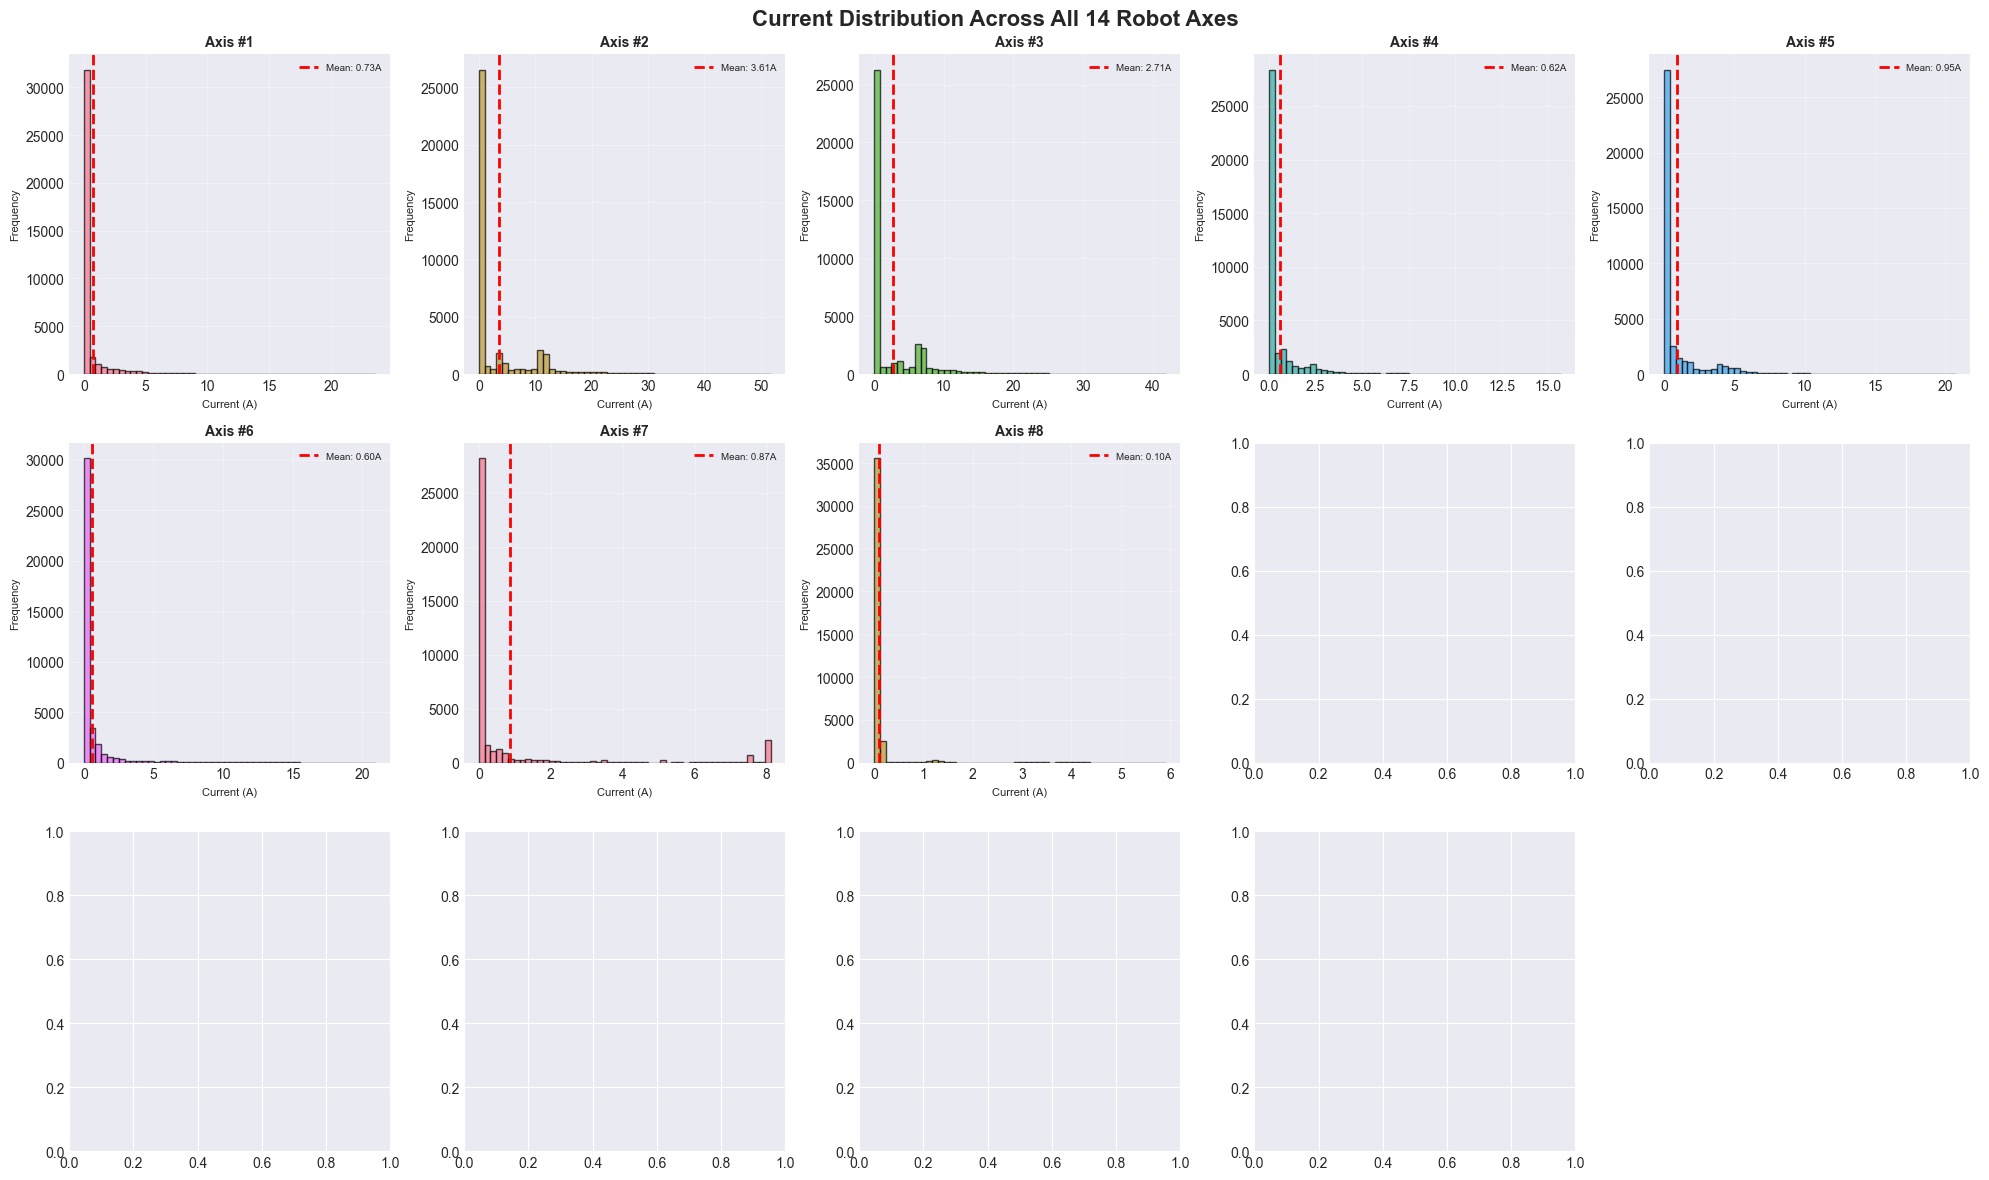

In [8]:
print("=" * 80)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 80)

# Visualization 1: Current Distribution Across All Axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Current Distribution Across All 14 Robot Axes', 
             fontsize=16, fontweight='bold')

for idx, axis in enumerate(ss.axis_columns):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    data = ss.df[axis].dropna()
    
    if len(data) > 0:
        ax.hist(data, bins=50, color=f'C{idx}', alpha=0.7, edgecolor='black')
        ax.axvline(data.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {data.mean():.2f}A')
        ax.set_title(f'{axis}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Current (A)', fontsize=8)
        ax.set_ylabel('Frequency', fontsize=8)
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)

axes[2, 4].axis('off')
plt.tight_layout()
plt.show()

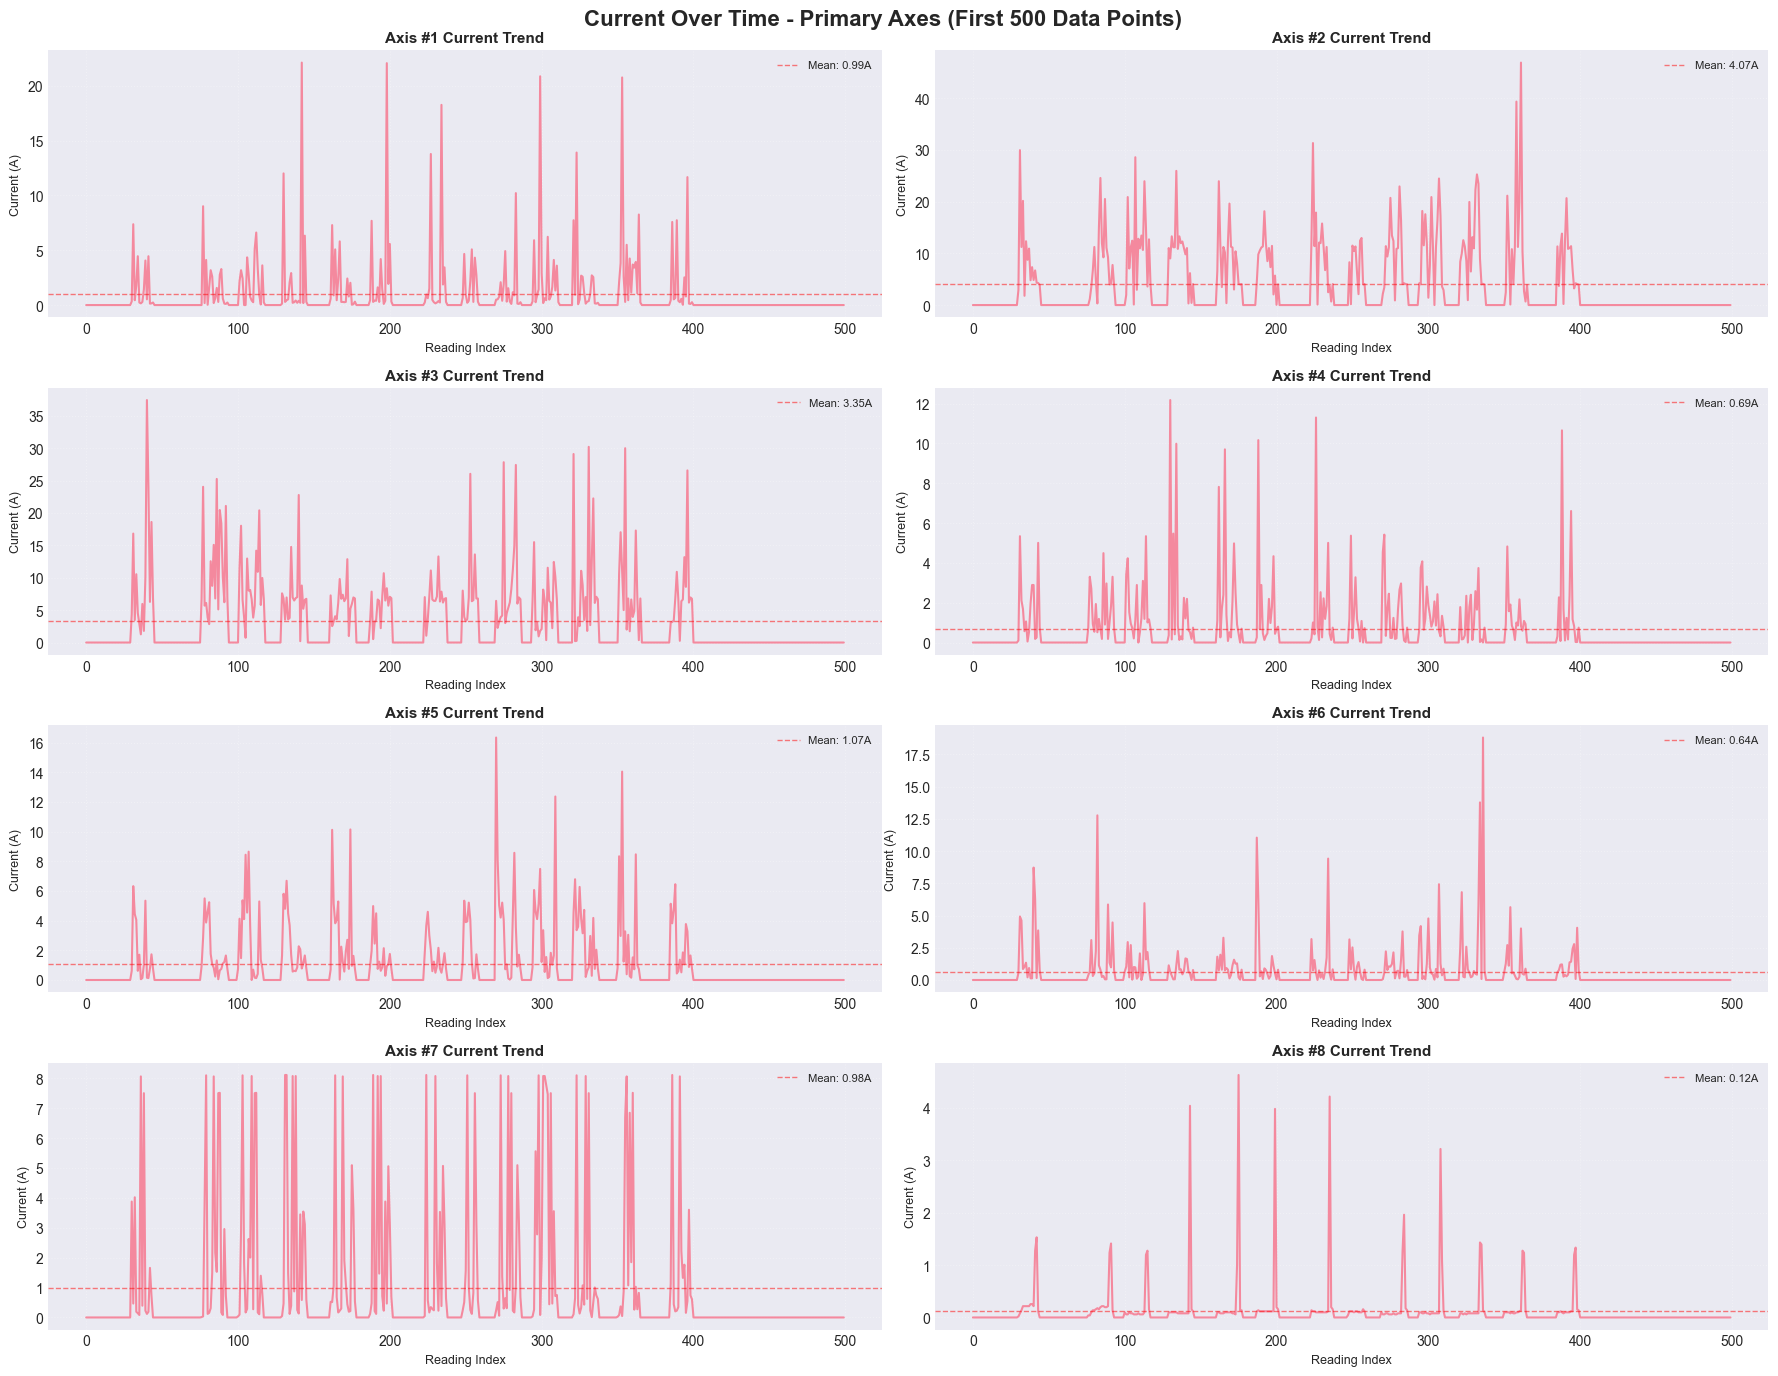

In [9]:
# Visualization 2: Time Series Overview (First 500 points)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
fig.suptitle('Current Over Time - Primary Axes (First 500 Data Points)', 
             fontsize=16, fontweight='bold')

sample_data = ss.df.head(500)
primary_axes = ss.axis_columns[:8]

for idx, axis in enumerate(primary_axes):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    data = sample_data[axis].dropna()
    ax.plot(data.index, data.values, linewidth=1.5, alpha=0.8)
    ax.set_title(f'{axis} Current Trend', fontsize=11, fontweight='bold')
    ax.set_xlabel('Reading Index', fontsize=9)
    ax.set_ylabel('Current (A)', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.axhline(data.mean(), color='red', linestyle='--', 
              linewidth=1, alpha=0.5, label=f'Mean: {data.mean():.2f}A')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


📊 Generating correlation analysis...


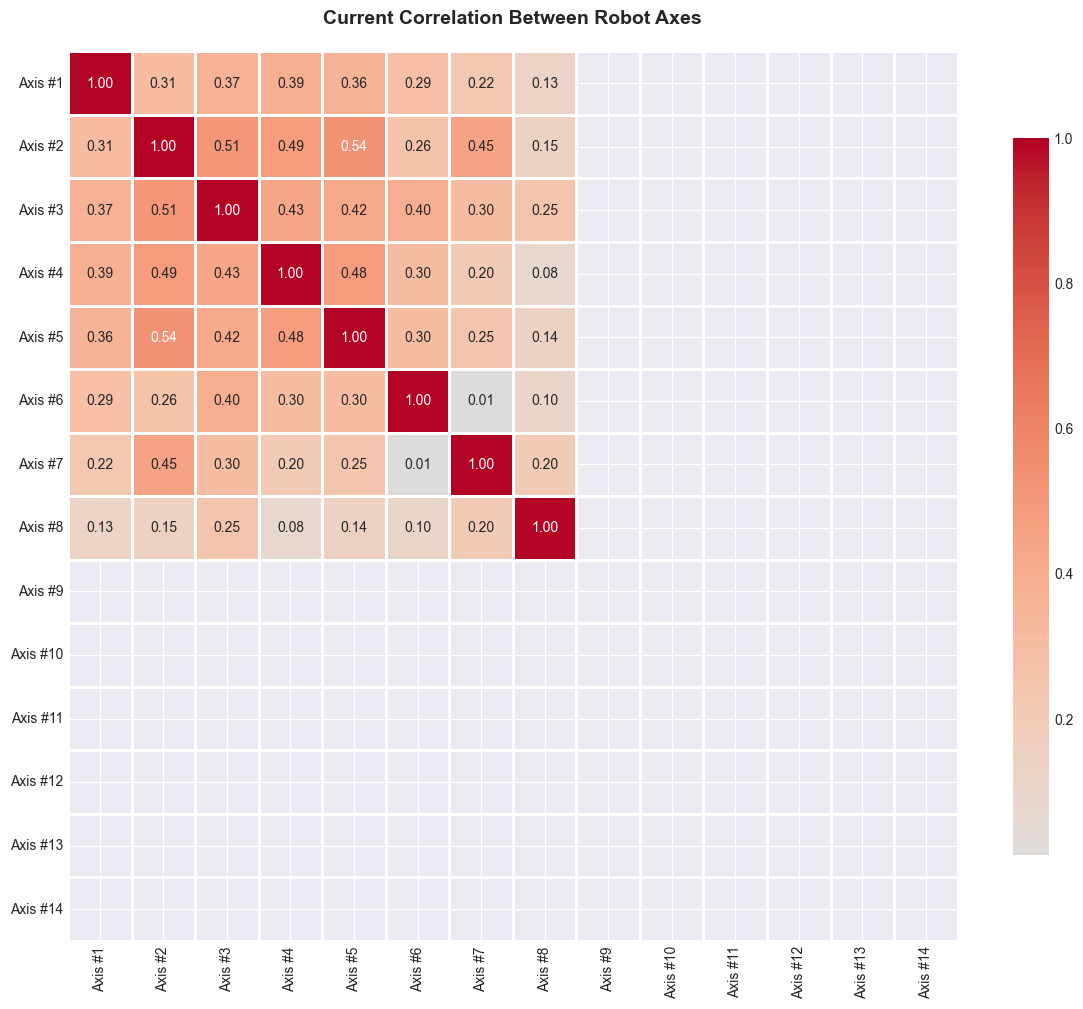


Correlation Insights:
- High positive correlation (>0.7): Axes moving together (coordinated motion)
- High negative correlation (<-0.7): Compensating movements
- Low correlation (~0): Independent axis operations



In [10]:
# Visualization 3: Correlation Heatmap
print("\n📊 Generating correlation analysis...")
correlation_matrix = ss.df[ss.axis_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Current Correlation Between Robot Axes', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("""
Correlation Insights:
- High positive correlation (>0.7): Axes moving together (coordinated motion)
- High negative correlation (<-0.7): Compensating movements
- Low correlation (~0): Independent axis operations
""")

## STEP 3: Anomaly Detection and Analysis

### Statistical Anomaly Detection for Multi-Axis Robot Systems

**Methodology:**

We employ statistical process control (SPC) methods to identify anomalies:
- Calculate mean (μ) and standard deviation (σ) for each axis
- Define control limits: μ ± 2.5σ (captures 98.76% of normal data)
- Flag data points outside control limits as anomalies

**Anomaly Categories:**

1. **Positive Spikes**: Current exceeds upper threshold
   - Indicates: Overload, jamming, mechanical resistance
   
2. **Negative Drops**: Current below lower threshold
   - Indicates: Loss of load, disconnection, calibration drift
   
3. **High Variability**: Frequent threshold crossings
   - Indicates: Unstable operation, vibration, loose components

In [11]:
print("=" * 80)
print("ANOMALY DETECTION ANALYSIS")
print("=" * 80)

anomalies = ss.detect_anomalies(threshold_multiplier=2.5)

if not anomalies:
    print("\n✅ NO ANOMALIES DETECTED in current data stream")
    print("All axes operating within normal parameters.")
else:
    print(f"\n⚠️  ANOMALIES DETECTED: {len(anomalies)} axes affected\n")
    
    for axis, details in anomalies.items():
        print(f"\n{'='*70}")
        print(f"🔍 {axis} - {details['severity']} SEVERITY")
        print(f"{'='*70}")
        print(f"   Anomaly Count: {len(details['indices'])} occurrences")
        print(f"   Mean Current: {details['mean']:.3f} A")
        print(f"   Std Deviation: {details['std']:.3f} A")
        print(f"   Upper Threshold: {details['threshold_upper']:.3f} A")
        print(f"   Lower Threshold: {details['threshold_lower']:.3f} A")
        print(f"   Anomalous Readings:")
        
        for i, (idx, val) in enumerate(zip(details['indices'][:5], 
                                           details['values'][:5])):
            print(f"      [{i+1}] Index {idx}: {val:.3f} A " + 
                  f"({'↑' if val > details['threshold_upper'] else '↓'} " +
                  f"{abs(val - details['mean']):.2f}A from mean)")
        
        if len(details['indices']) > 5:
            print(f"      ... and {len(details['indices']) - 5} more")

ANOMALY DETECTION ANALYSIS

⚠️  ANOMALIES DETECTED: 8 axes affected


🔍 Axis #1 - HIGH SEVERITY
   Anomaly Count: 1242 occurrences
   Mean Current: 0.726 A
   Std Deviation: 2.162 A
   Upper Threshold: 6.131 A
   Lower Threshold: -4.680 A
   Anomalous Readings:
      [1] Index 31: 7.375 A (↑ 6.65A from mean)
      [2] Index 77: 9.016 A (↑ 8.29A from mean)
      [3] Index 112: 6.619 A (↑ 5.89A from mean)
      [4] Index 130: 12.013 A (↑ 11.29A from mean)
      [5] Index 142: 22.124 A (↑ 21.40A from mean)
      ... and 1237 more

🔍 Axis #2 - HIGH SEVERITY
   Anomaly Count: 1354 occurrences
   Mean Current: 3.613 A
   Std Deviation: 6.880 A
   Upper Threshold: 20.813 A
   Lower Threshold: -13.587 A
   Anomalous Readings:
      [1] Index 31: 29.942 A (↑ 26.33A from mean)
      [2] Index 84: 24.565 A (↑ 20.95A from mean)
      [3] Index 102: 20.875 A (↑ 17.26A from mean)
      [4] Index 107: 28.571 A (↑ 24.96A from mean)
      [5] Index 113: 23.933 A (↑ 20.32A from mean)
      ... and 1349 

## Cell 5: Axis Health Analysis

In [12]:
print("=" * 80)
print("ROBOT AXIS HEALTH ASSESSMENT")
print("=" * 80)

health_report = ss.analyze_axis_health()

if health_report:
    print(f"\nAnalyzing {len(health_report)} active axes...\n")
    
    for axis, metrics in sorted(health_report.items()):
        print(f"{metrics['color']} {axis}: {metrics['status']}")
        print(f"   Mean Current: {metrics['mean_current']:.3f} A")
        print(f"   Std Deviation: {metrics['std_current']:.3f} A")
        print(f"   Max Current: {metrics['max_current']:.3f} A")
        print(f"   Variability (CV): {metrics['coefficient_of_variation']:.1f}%")
        print(f"   Data Points: {metrics['data_points']}")
        print()

ROBOT AXIS HEALTH ASSESSMENT

Analyzing 8 active axes...

🔴 Axis #1: CRITICAL - High variability
   Mean Current: 0.726 A
   Std Deviation: 2.162 A
   Max Current: 23.609 A
   Variability (CV): 297.9%
   Data Points: 39672

🔴 Axis #2: CRITICAL - High variability
   Mean Current: 3.613 A
   Std Deviation: 6.880 A
   Max Current: 51.713 A
   Variability (CV): 190.4%
   Data Points: 39672

🔴 Axis #3: CRITICAL - High variability
   Mean Current: 2.710 A
   Std Deviation: 5.112 A
   Max Current: 41.856 A
   Variability (CV): 188.6%
   Data Points: 39672

🔴 Axis #4: CRITICAL - High variability
   Mean Current: 0.620 A
   Std Deviation: 1.575 A
   Max Current: 15.666 A
   Variability (CV): 253.9%
   Data Points: 39672

🔴 Axis #5: CRITICAL - High variability
   Mean Current: 0.955 A
   Std Deviation: 2.100 A
   Max Current: 20.751 A
   Variability (CV): 220.0%
   Data Points: 39672

🔴 Axis #6: CRITICAL - High variability
   Mean Current: 0.599 A
   Std Deviation: 1.815 A
   Max Current: 20.931

## STEP 4: Maintenance Notification System

### AI-Driven Maintenance Alert Generation

**Alert Priority Levels:**
- 🔴 CRITICAL: Immediate action required (safety risk, imminent failure)
- 🟠 HIGH: Schedule maintenance within 24 hours
- 🟡 MEDIUM: Monitor closely, schedule within week
- 🟢 LOW: Informational, routine check recommended

**Alert Triggers:**
- Anomaly persistence (>5 occurrences in 100 readings)
- High coefficient of variation (>50%)
- Sustained high current draw (>25A for extended period)
- Correlation breakdown between coordinated axes

In [13]:
print("=" * 80)
print("MAINTENANCE NOTIFICATION ALERTS")
print("=" * 80)

maintenance_alerts = []

if anomalies:
    for axis, details in anomalies.items():
        axis_num = axis.replace('Axis #', '')
        
        if details['severity'] == 'HIGH' and details['mean'] > 20:
            alert = {
                'priority': '🔴 CRITICAL',
                'axis': axis,
                'issue': f'Excessive current draw with high anomaly rate',
                'recommendation': f'IMMEDIATE INSPECTION: Check {axis} motor, bearings, and mechanical alignment. High current ({details["mean"]:.2f}A avg) indicates severe mechanical resistance.',
                'affected_readings': len(details['indices']),
                'estimated_downtime': '2-4 hours',
                'parts_needed': f'Motor bearings, {axis} drive components'
            }
            maintenance_alerts.append(alert)
            
        elif details['severity'] == 'HIGH':
            alert = {
                'priority': '🟠 HIGH',
                'axis': axis,
                'issue': 'Current instability detected',
                'recommendation': f'Schedule maintenance within 24h: Inspect {axis} for loose connections, encoder issues, or intermittent load problems.',
                'affected_readings': len(details['indices']),
                'estimated_downtime': '1-2 hours',
                'parts_needed': 'Inspection kit, multimeter'
            }
            maintenance_alerts.append(alert)
        
        else:
            alert = {
                'priority': '🟡 MEDIUM',
                'axis': axis,
                'issue': 'Minor current fluctuations',
                'recommendation': f'Monitor {axis} during next scheduled maintenance. Document anomaly pattern for trend analysis.',
                'affected_readings': len(details['indices']),
                'estimated_downtime': '30 minutes',
                'parts_needed': 'None (inspection only)'
            }
            maintenance_alerts.append(alert)

if health_report:
    for axis, metrics in health_report.items():
        if 'CRITICAL' in metrics['status'] and axis not in [a['axis'] for a in maintenance_alerts]:
            alert = {
                'priority': '🔴 CRITICAL',
                'axis': axis,
                'issue': 'High variability in current draw',
                'recommendation': f'IMMEDIATE: {axis} showing erratic behavior (CV: {metrics["coefficient_of_variation"]:.1f}%). Potential mechanical failure or electrical fault.',
                'affected_readings': metrics['data_points'],
                'estimated_downtime': '3-6 hours',
                'parts_needed': f'{axis} motor assembly, drive controller'
            }
            maintenance_alerts.append(alert)

if not maintenance_alerts:
    print("\n✅ NO MAINTENANCE ALERTS")
    print("All robot axes operating within acceptable parameters.\n")
    print("Recommended Actions:")
    print("  • Continue normal operation")
    print("  • Maintain regular preventive maintenance schedule")
    print("  • Monitor for emerging patterns")
else:
    print(f"\n⚠️  {len(maintenance_alerts)} MAINTENANCE ALERT(S) GENERATED\n")
    
    priority_order = {'🔴 CRITICAL': 0, '🟠 HIGH': 1, '🟡 MEDIUM': 2, '🟢 LOW': 3}
    maintenance_alerts.sort(key=lambda x: priority_order.get(x['priority'], 99))
    
    for idx, alert in enumerate(maintenance_alerts, 1):
        print(f"\n{'━'*70}")
        print(f"ALERT #{idx} - {alert['priority']}")
        print(f"{'━'*70}")
        print(f"Affected Component: {alert['axis']}")
        print(f"Issue Identified: {alert['issue']}")
        print(f"Affected Readings: {alert['affected_readings']}")
        print(f"\n📋 RECOMMENDATION:")
        print(f"   {alert['recommendation']}")
        print(f"\n⏱️  Estimated Downtime: {alert['estimated_downtime']}")
        print(f"🔧 Parts/Tools: {alert['parts_needed']}")

print("\n" + "=" * 80)

MAINTENANCE NOTIFICATION ALERTS

⚠️  8 MAINTENANCE ALERT(S) GENERATED


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ALERT #1 - 🟠 HIGH
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Affected Component: Axis #1
Issue Identified: Current instability detected
Affected Readings: 1242

📋 RECOMMENDATION:
   Schedule maintenance within 24h: Inspect Axis #1 for loose connections, encoder issues, or intermittent load problems.

⏱️  Estimated Downtime: 1-2 hours
🔧 Parts/Tools: Inspection kit, multimeter

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ALERT #2 - 🟠 HIGH
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Affected Component: Axis #2
Issue Identified: Current instability detected
Affected Readings: 1354

📋 RECOMMENDATION:
   Schedule maintenance within 24h: Inspect Axis #2 for loose connections, encoder issues, or intermittent load problems.

⏱️  Estimated Downtime: 1-2 hours
🔧 Parts/Tools: 

### Impact Assessment on Robot State

The detected anomalies can impact robot operations in several ways:

**1. Current Spikes (>30A):**
- Immediate impact: Potential motor overheating
- Short-term: Reduced precision, increased energy costs
- Long-term: Motor burnout, controller damage
- Safety: Possible thermal shutdown, fire risk

**2. High Variability (CV >50%):**
- Immediate impact: Inconsistent operation, quality issues
- Short-term: Vibration, reduced accuracy
- Long-term: Accelerated wear, bearing failure
- Safety: Unpredictable movements, collision risk

**3. Persistent Anomalies (>10 in 100 readings):**
- Immediate impact: System instability
- Short-term: Increased failure probability
- Long-term: Cascading failures across axes
- Safety: Loss of control, emergency stop triggers

**4. Multi-Axis Anomalies:**
- Immediate impact: Coordinated motion breakdown
- Short-term: Production quality degradation
- Long-term: Structural damage to robot frame
- Safety: Dangerous trajectory deviations

**Recommendation:** Address CRITICAL alerts immediately, HIGH within 24h, MEDIUM during next maintenance window. Defer LOW alerts to routine service.

## STEP 5: Database Retrieval and Energy/Current Analysis

### Comprehensive Analysis of Robot Power Consumption

This section retrieves all streamed data from the database and performs in-depth analysis of current draw patterns across all axes.

**Current draw directly correlates with:**
- Mechanical workload
- Energy consumption (Power = Voltage × Current)
- Motor efficiency
- Operational costs

In [14]:
print("=" * 80)
print("DATABASE DATA RETRIEVAL AND ANALYSIS")
print("=" * 80)

db_data = ss.get_all_data_from_db()

if db_data is not None and len(db_data) > 0:
    print(f"\n✅ Database Query Successful")
    print(f"   Records retrieved: {len(db_data):,}")
    print(f"   Columns: {list(db_data.columns)}")
    print(f"   Date range: {db_data['timestamp'].min()} to {db_data['timestamp'].max()}")
    print(f"   Time span: {db_data['timestamp'].max() - db_data['timestamp'].min()}")
    
    axis_cols = [f'axis_{i}' for i in range(1, 15)]
    
    for col in axis_cols:
        if col in db_data.columns:
            db_data[col] = pd.to_numeric(db_data[col], errors='coerce')
    
    db_data['total_current'] = db_data[axis_cols].sum(axis=1, skipna=True)
    
    total_current_clean = db_data['total_current'].dropna()
    indices_clean = db_data.index[db_data['total_current'].notna()]
    
    print(f"\n📊 CURRENT CONSUMPTION SUMMARY")
    print(f"   {'─'*60}")
    
    if 'total_current' in db_data.columns and len(total_current_clean) > 0:
        print(f"   Total Current (All Axes):")
        print(f"      Mean: {total_current_clean.mean():.2f} A")
        print(f"      Median: {total_current_clean.median():.2f} A")
        print(f"      Std Dev: {total_current_clean.std():.2f} A")
        print(f"      Min: {total_current_clean.min():.2f} A")
        print(f"      Max: {total_current_clean.max():.2f} A")
        print(f"      95th Percentile: {total_current_clean.quantile(0.95):.2f} A")
        
        voltage = 480
        avg_power_kw = (total_current_clean.mean() * voltage) / 1000
        total_energy_kwh = (total_current_clean.sum() * voltage * 2) / (1000 * 3600)
        
        print(f"\n⚡ ENERGY CONSUMPTION ESTIMATES (assuming {voltage}V)")
        print(f"   {'─'*60}")
        print(f"   Average Power Draw: {avg_power_kw:.2f} kW")
        print(f"   Estimated Total Energy: {total_energy_kwh:.2f} kWh")
        print(f"   Estimated Cost (@$0.12/kWh): ${total_energy_kwh * 0.12:.2f}")
    else:
        print("   ⚠️ Unable to calculate statistics - insufficient data")

DATABASE DATA RETRIEVAL AND ANALYSIS
✅ Retrieved 39672 records from database

✅ Database Query Successful
   Records retrieved: 39,672
   Columns: ['id', 'trait', 'axis_1', 'axis_2', 'axis_3', 'axis_4', 'axis_5', 'axis_6', 'axis_7', 'axis_8', 'axis_9', 'axis_10', 'axis_11', 'axis_12', 'axis_13', 'axis_14', 'timestamp', 'created_at']
   Date range: 2022-10-17 12:18:23.660000 to 2022-10-18 10:44:58.628000
   Time span: 0 days 22:26:34.968000

📊 CURRENT CONSUMPTION SUMMARY
   ────────────────────────────────────────────────────────────
   Total Current (All Axes):
      Mean: 10.20 A
      Median: 0.00 A
      Std Dev: 15.71 A
      Min: 0.00 A
      Max: 88.14 A
      95th Percentile: 42.71 A

⚡ ENERGY CONSUMPTION ESTIMATES (assuming 480V)
   ────────────────────────────────────────────────────────────
   Average Power Draw: 4.89 kW
   Estimated Total Energy: 107.87 kWh
   Estimated Cost (@$0.12/kWh): $12.94


## Cell 6: Comprehensive Current Analysis Visualizations

GENERATING COMPREHENSIVE CURRENT ANALYSIS


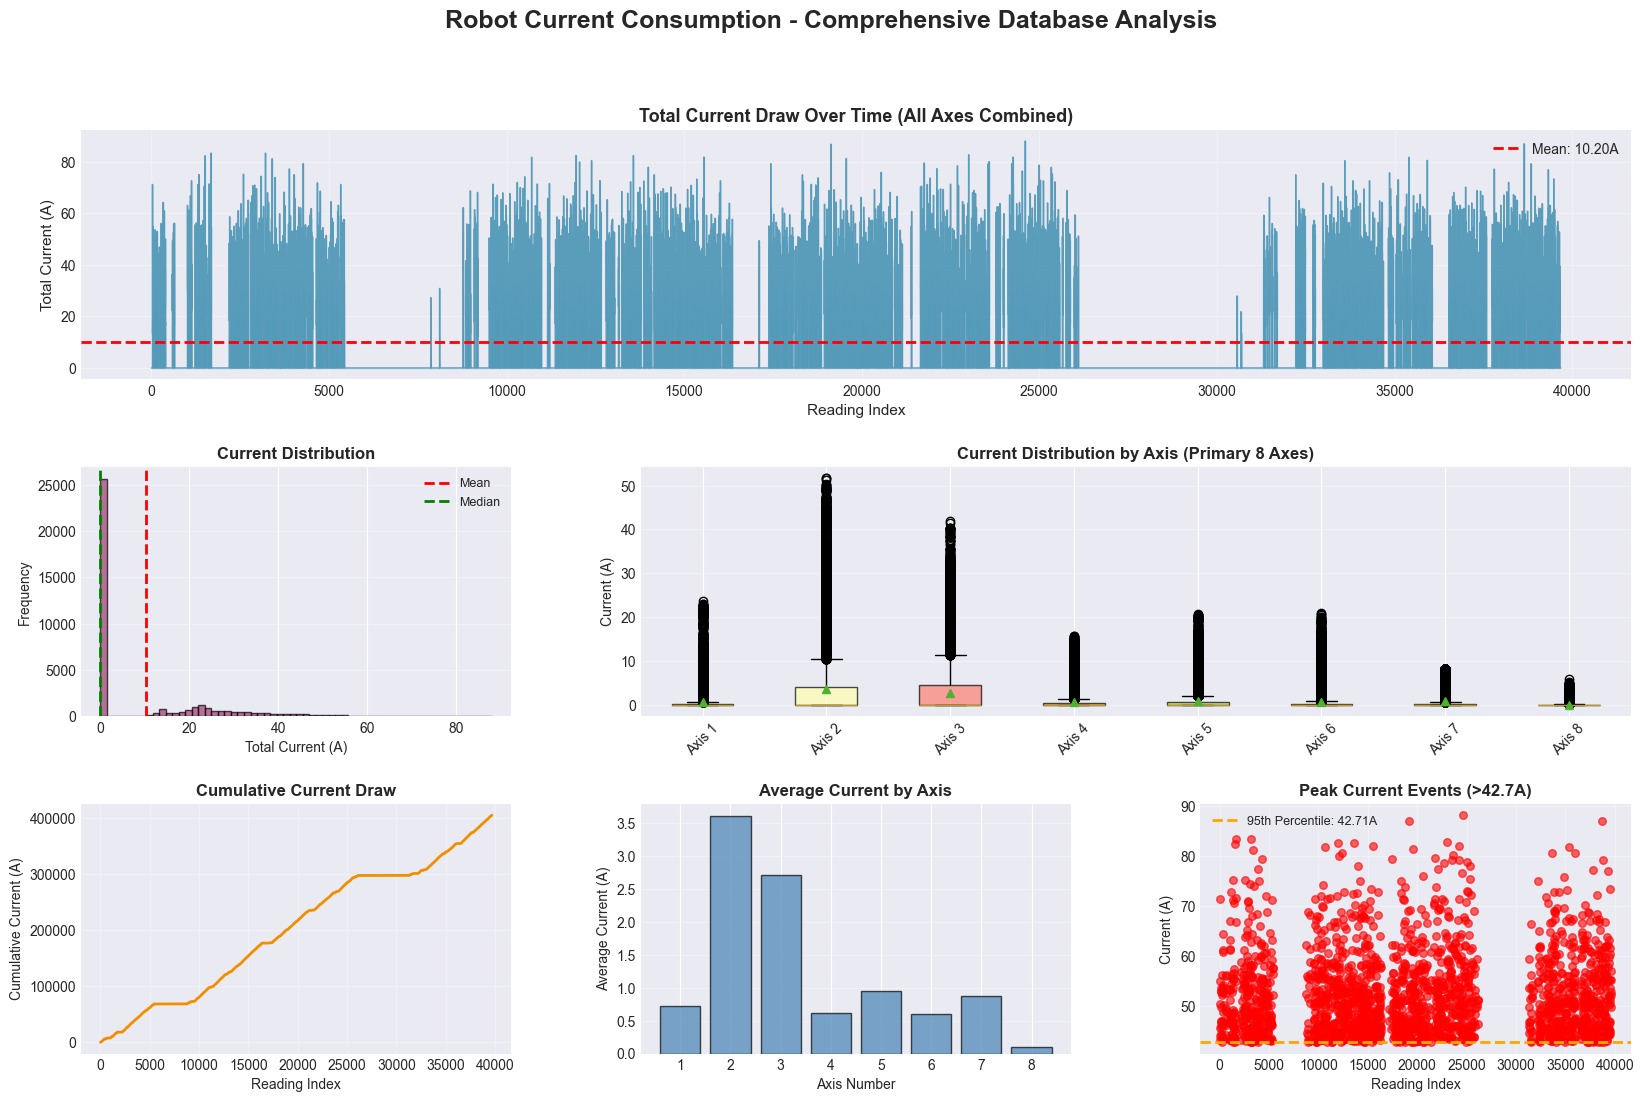


✅ Visualization complete
   Peak events detected: 1984
   Peak threshold: 42.71 A


In [15]:
print("=" * 80)
print("GENERATING COMPREHENSIVE CURRENT ANALYSIS")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

fig.suptitle('Robot Current Consumption - Comprehensive Database Analysis', 
             fontsize=18, fontweight='bold')

# Plot 1: Total Current Over Time
ax1 = fig.add_subplot(gs[0, :])
total_current_clean = db_data['total_current'].dropna()
indices_clean = db_data.index[db_data['total_current'].notna()]

if len(total_current_clean) > 0:
    ax1.plot(indices_clean, total_current_clean, 
            color='#2E86AB', linewidth=1, alpha=0.7)
    ax1.fill_between(indices_clean, total_current_clean, 
                     alpha=0.2, color='#2E86AB')
    ax1.axhline(total_current_clean.mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Mean: {total_current_clean.mean():.2f}A')
    ax1.set_title('Total Current Draw Over Time (All Axes Combined)', 
                 fontsize=13, fontweight='bold')
    ax1.set_xlabel('Reading Index', fontsize=11)
    ax1.set_ylabel('Total Current (A)', fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

# Plot 2: Current Distribution
ax2 = fig.add_subplot(gs[1, 0])
if len(total_current_clean) > 0:
    ax2.hist(total_current_clean, bins=60, color='#A23B72', 
            edgecolor='black', alpha=0.7)
    ax2.axvline(total_current_clean.mean(), color='red', 
               linestyle='--', linewidth=2, label='Mean')
    ax2.axvline(total_current_clean.median(), color='green', 
               linestyle='--', linewidth=2, label='Median')
    ax2.set_title('Current Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Total Current (A)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Box Plot Per Axis
ax3 = fig.add_subplot(gs[1, 1:])
axis_data_list = []
axis_labels = []
for i in range(1, 9):
    col = f'axis_{i}'
    if col in db_data.columns:
        axis_vals = pd.to_numeric(db_data[col], errors='coerce').dropna()
        if len(axis_vals) > 0:
            axis_data_list.append(axis_vals)
            axis_labels.append(f'Axis {i}')

if len(axis_data_list) > 0:
    bp = ax3.boxplot(axis_data_list, labels=axis_labels,
                    patch_artist=True, showmeans=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(axis_data_list)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.set_title('Current Distribution by Axis (Primary 8 Axes)', 
                 fontsize=12, fontweight='bold')
    ax3.set_ylabel('Current (A)', fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=45)

# Plot 4: Cumulative Current
ax4 = fig.add_subplot(gs[2, 0])
if len(total_current_clean) > 0:
    ax4.plot(indices_clean, total_current_clean.cumsum(), 
            color='#F18F01', linewidth=2)
    ax4.set_title('Cumulative Current Draw', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Reading Index', fontsize=10)
    ax4.set_ylabel('Cumulative Current (A)', fontsize=10)
    ax4.grid(True, alpha=0.3)

# Plot 5: Per-Axis Average Current
ax5 = fig.add_subplot(gs[2, 1])
avg_currents = []
axis_numbers = []
for i in range(1, 15):
    col = f'axis_{i}'
    if col in db_data.columns:
        avg_val = pd.to_numeric(db_data[col], errors='coerce').mean()
        if pd.notna(avg_val):
            avg_currents.append(avg_val)
            axis_numbers.append(i)

if len(avg_currents) > 0:
    ax5.bar(axis_numbers, avg_currents, color='steelblue', alpha=0.7, edgecolor='black')
    ax5.set_title('Average Current by Axis', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Axis Number', fontsize=10)
    ax5.set_ylabel('Average Current (A)', fontsize=10)
    ax5.set_xticks(axis_numbers)
    ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Peak Current Events
ax6 = fig.add_subplot(gs[2, 2])
peak_events = pd.DataFrame()
peak_threshold = 0
if len(total_current_clean) > 0:
    peak_threshold = total_current_clean.quantile(0.95)
    peak_mask = db_data['total_current'] > peak_threshold
    peak_events = db_data[peak_mask]
    
    if len(peak_events) > 0:
        ax6.scatter(peak_events.index, peak_events['total_current'], 
                   color='red', s=30, alpha=0.6)
        ax6.axhline(peak_threshold, color='orange', linestyle='--', 
                   linewidth=2, label=f'95th Percentile: {peak_threshold:.2f}A')
        ax6.set_title(f'Peak Current Events (>{peak_threshold:.1f}A)', 
                     fontsize=12, fontweight='bold')
        ax6.set_xlabel('Reading Index', fontsize=10)
        ax6.set_ylabel('Current (A)', fontsize=10)
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if len(total_current_clean) > 0 and len(peak_events) > 0:
    print(f"\n✅ Visualization complete")
    print(f"   Peak events detected: {len(peak_events)}")
    print(f"   Peak threshold: {peak_threshold:.2f} A")
else:
    print(f"\n⚠️ Visualization generated with available data")